## Hateful Tweet Selection

This notebook implements selection of hateful tweets from the annotated tweets. The selection is based on the following criteria:
- The tweet is annotated as hateful against a target group by three annotators
- The tweet is Turkish 

In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv('../data/all_tweets_121024.csv')
df

,genel_tutum,hedef_grup,derece,kategori,saldırgan_dil,tweet_text,annotator,uploaded_at,konu,tweet_id,dil
0,Irrelevant,['Specific Opinion/Status/Practice; Profession...,0,['There is no hate speech'],NaN,قبل انتخابات الرئاسة بأيام.. #أردوغان يرفع الح...,Majd,2024-04-25T12:53:59,Arabic,1656005366709198858,NaN
1,Neutral,['Specific Opinion/Status/Practice; Profession...,0,['There is no hate speech'],NaN,ياعم لقد أشرف نصفها على الانتهاء وأنتم لم تفص...,Majd,2024-04-25T12:53:59,Arabic,1655525177541664771,NaN
2,Irrelevant,['Specific Opinion/Status/Practice; Profession...,0,['There is no hate speech'],NaN,"مرشح تحالف الأجداد ""سنان #أوغان"" كان حلّ في ال...",Majd,2024-04-25T12:53:59,Arabic,1659346836115554311,NaN
3,Irrelevant,['Specific Opinion/Status/Practice; Profession...,0,['There is no hate speech'],NaN,#روسيا تراقب.. #انتخابات_تركيا تظهر أزمة في ال...,Majd,2024-04-25T12:53:59,Arabic,1658094922254241792,NaN
4,Irrelevant,['Target group is unclear or absent'],0,['There is no hate speech'],NaN,شهر واحد بس من بياناتك الاساسية اذا بقين تترحل...,Majd,2024-04-25T12:53:59,Arabic,1659632718651506724,NaN
...,...,...,...,...,...,...,...,...,...,...,...
51424,Irrelevant,['Specific Opinion/Status/Practice; Profession...,0,['There is no hate speech'],NaN,جرب اتكلم ببلادك وخلينا نشوف حرية التعبير عندك...,Majd,2024-07-16T19:55:11,Arabic,1661595099338272768,NaN
51425,Not Sure,['Target group is unclear or absent'],Not Sure,['Not sure'],NaN,لانهم رجال الشدائد لا يقبلون الضيم وليسوا جبنا...,Majd,2024-07-16T19:55:11,Arabic,1662871281849495556,NaN
51426,Irrelevant,['Specific Opinion/Status/Practice; Profession...,0,['There is no hate speech'],NaN,تنفيذ حكم القتل في إرهابيان بحريني الجنسيه هذا...,Majd,2024-07-16T19:55:11,Arabic,1663362300034662400,NaN
51427,Irrelevant,['Specific Opinion/Status/Practice; Profession...,0,['There is no hate speech'],NaN,الغالبية ممن هم في هذة القائمة ليسو محكومين بح...,Majd,2024-07-16T19:55:11,Arabic,1662793752417632256,NaN


In [3]:
df['genel_tutum'].value_counts()

genel_tutum
Nötr                      13670
Alakasız                   7987
Irrelevant                 7148
Göçmen/Mülteci Karşıtı     5278
Yunan Karşıtı              3397
Yahudi Karşıtı             3108
Emin değilim               2354
Ermeni Karşıtı             2010
Arap Karşıtı               1339
Anti-Immigrant/Refugee      929
Neutral                     511
Not Sure                    435
Alevi Karşıtı               423
Kürt Karşıtı                276
Türkçe değil                265
LGBTI+ Karşıtı              240
Name: count, dtype: int64

In [4]:
df.drop_duplicates(subset='tweet_id')['genel_tutum'].value_counts() 

genel_tutum
Nötr                      4030
Alakasız                  3936
Irrelevant                2798
Göçmen/Mülteci Karşıtı    1749
Yahudi Karşıtı            1345
Yunan Karşıtı             1226
Emin değilim               670
Ermeni Karşıtı             602
Arap Karşıtı               468
Anti-Immigrant/Refugee     388
Alevi Karşıtı              217
Neutral                    181
Not Sure                   148
Türkçe değil               121
Kürt Karşıtı                90
LGBTI+ Karşıtı              82
Name: count, dtype: int64

In [24]:
target_groups = [
    'Göçmen/Mülteci Karşıtı', 
    'Yunan Karşıtı', 
    'Yahudi Karşıtı', 
    'Ermeni Karşıtı', 'Arap Karşıtı', 
    'Anti-Immigrant/Refugee',
    'LGBTI+ Karşıtı',
    'Kürt Karşıtı',
    'Alevi Karşıtı'
]

In [39]:
# Function to keep groups with at least two rows and a majority value in genel_tutum
def process_group(group):
    
    # Proceed only if the group has more than 2 rows
    if len(group) > 2:
        try: 
            # Get the most common value in the 'genel_tutum' column
            most_common_value = group['genel_tutum'].value_counts().idxmax()
            
            # Check if the most common value belongs to the predefined majority values
            if most_common_value in target_groups:
                group['majority_decision'] = most_common_value
                return group
        except: # empty sequence?
            return None 
    
    return None

# Apply the function to the grouped dataframe
df_majority = df.groupby('tweet_id').apply(process_group).reset_index(drop=True)
df_majority

/var/folders/f7/102m7ghj1qd6dbkw723c7tq00000gn/T/ipykernel_884/2481936138.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_majority = df.groupby('tweet_id').apply(process_group).reset_index(drop=True)


,genel_tutum,hedef_grup,derece,kategori,saldırgan_dil,tweet_text,annotator,uploaded_at,konu,tweet_id,dil,majority_decision
0,Yahudi Karşıtı,['Ülke/Milliyet'],4,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,#Katilİsrail https://t.co/A2uX5Uygxs,Göksu,2023-01-10T20:07:20,Isr-Pal,1353048938450976770,NaN,Yahudi Karşıtı
1,Yahudi Karşıtı,['Ülke/Milliyet'],6,['Düşmanlık; Savaş; Saldırı; Öldürme; Yaralama...,Yok,#Katilİsrail https://t.co/A2uX5Uygxs,Ceren,2023-01-10T19:48:53,Isr-Pal,1353048938450976770,NaN,Yahudi Karşıtı
2,Yahudi Karşıtı,['Ülke/Milliyet'],7,['Abartma; Genelleme; Yükleme; Çarpıtma'],Şiddetli,#Katilİsrail https://t.co/A2uX5Uygxs,Ebrar,2023-01-10T19:59:49,Isr-Pal,1353048938450976770,NaN,Yahudi Karşıtı
3,Yahudi Karşıtı,['Ülke/Milliyet'],6,"['Simgeleştirme', 'Düşmanlık; Savaş; Saldırı; ...",Yok,#Katilİsrail https://t.co/IZL3a33jCI,Erdem,2023-04-03T14:29:29,Isr-Pal,1353049567248457729,Türkçe,Yahudi Karşıtı
4,Nötr,['Hedef grup belirgin değil veya yok.'],0,['Nefret söylemi bulunmuyor'],Yok,#Katilİsrail https://t.co/IZL3a33jCI,Mehmet,2023-03-14T07:42:36,Isr-Pal,1353049567248457729,Türkçe,Yahudi Karşıtı
...,...,...,...,...,...,...,...,...,...,...,...,...
16721,Anti-Immigrant/Refugee,['Country/Nationality'],5,['Exaggeration; Generalization; Attribution; D...,NaN,الجنسية اليمنية\nأكثر جنسية تم ضبطها\nفي الحمل...,İsla,2024-04-25T12:54:19,Arabic,1660070744703868928,NaN,Anti-Immigrant/Refugee
16722,Anti-Immigrant/Refugee,['Country/Nationality'],6,['Exaggeration; Generalization; Attribution; D...,NaN,الجنسية اليمنية\nأكثر جنسية تم ضبطها\nفي الحمل...,Neda,2024-04-08T12:14:51,Arabic,1660070744703868928,NaN,Anti-Immigrant/Refugee
16723,Anti-Immigrant/Refugee,['Target group is unclear or absent'],7,['Swearing; Insult; Defamation; Dehumanization...,Low,داخليين السعوديه ومعهم متفجرات ويبون يذبحون ال...,İsla,2024-06-26T12:23:09,Arabic,1663559853313515523,NaN,Anti-Immigrant/Refugee
16724,Irrelevant,['Target group is unclear or absent'],0,['There is no hate speech'],NaN,داخليين السعوديه ومعهم متفجرات ويبون يذبحون ال...,Neda,2024-07-23T00:39:29,Arabic,1663559853313515523,NaN,Anti-Immigrant/Refugee


In [42]:
df_majority_target = df_majority[df_majority['majority_decision'].isin(target_groups)]
df_majority_target.drop_duplicates(subset=['tweet_id', 'majority_decision'])['majority_decision'].value_counts() 

majority_decision
Göçmen/Mülteci Karşıtı    1748
Yahudi Karşıtı            1217
Yunan Karşıtı             1129
Ermeni Karşıtı             636
Arap Karşıtı               338
Anti-Immigrant/Refugee     246
Alevi Karşıtı              128
Kürt Karşıtı                64
LGBTI+ Karşıtı              49
Name: count, dtype: int64

In [105]:
df_majority_candidates = df_majority_target.drop_duplicates(subset='tweet_id')
df_majority_candidates['majority_decision'].value_counts() 

majority_decision
Göçmen/Mülteci Karşıtı    1748
Yahudi Karşıtı            1217
Yunan Karşıtı             1129
Ermeni Karşıtı             636
Arap Karşıtı               338
Anti-Immigrant/Refugee     246
Alevi Karşıtı              128
Kürt Karşıtı                64
LGBTI+ Karşıtı              49
Name: count, dtype: int64

In [106]:
df_majority_candidates = df_majority_candidates.drop_duplicates(subset='tweet_text')
df_majority_candidates['majority_decision'].value_counts() 

majority_decision
Göçmen/Mülteci Karşıtı    1468
Yahudi Karşıtı            1200
Yunan Karşıtı             1121
Ermeni Karşıtı             635
Arap Karşıtı               338
Anti-Immigrant/Refugee     245
Alevi Karşıtı              127
Kürt Karşıtı                64
LGBTI+ Karşıtı              49
Name: count, dtype: int64

In [107]:
df_majority_candidates['tweet_text_len'] = df_majority_candidates['tweet_text'].apply(len)
df_majority_candidates['tweet_text_len'].describe()

count    5247.000000
mean      177.453211
std        87.454126
min        12.000000
25%       107.000000
50%       171.000000
75%       258.000000
max       792.000000
Name: tweet_text_len, dtype: float64

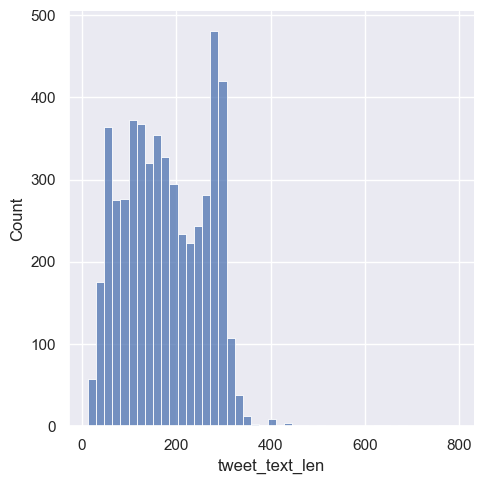

In [108]:
import seaborn as sns
sns.set()
sns.displot(df_majority_candidates['tweet_text_len'])

In [109]:
import re 
import string 

def clean_tweet(text, features='all'):
    
    # Remove usernames (words starting with @)
    text = re.sub(r'@\w+', '', text)
    
    # Remove links (URLs starting with http, https, www)
    text = re.sub(r'http\S+|www.\S+', '', text)

    if features == 'redundant': 
        return text 
    
     # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"  # enclosed characters
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Optionally, remove extra spaces created by removing usernames and links
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text.lower()

df_majority_candidates['tweet_text_clean'] = df_majority_candidates['tweet_text'].apply(lambda s: clean_tweet(s, "redundant"))
df_majority_candidates['temp_tweet'] = df_majority_candidates['tweet_text'].apply(clean_tweet)
df_majority_candidates['temp_tweet_len'] = df_majority_candidates['temp_tweet'].apply(len)

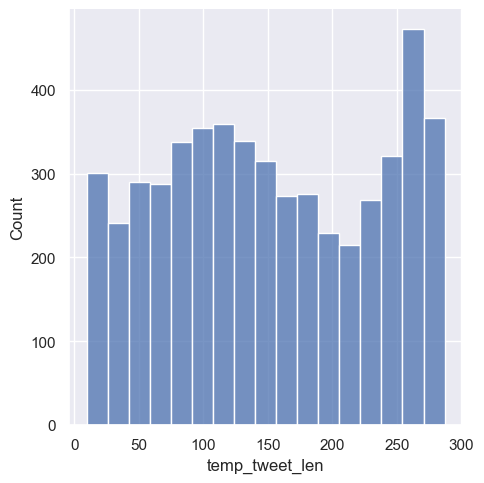

In [110]:
sns.displot(df_majority_candidates['temp_tweet_len'])

In [111]:
df_majority_candidates[df_majority_candidates['temp_tweet_len']< 20]

,genel_tutum,hedef_grup,derece,kategori,saldırgan_dil,tweet_text,annotator,uploaded_at,konu,tweet_id,dil,majority_decision,tweet_text_len,tweet_text_clean,temp_tweet,temp_tweet_len
0,Yahudi Karşıtı,['Ülke/Milliyet'],4,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,#Katilİsrail https://t.co/A2uX5Uygxs,Göksu,2023-01-10T20:07:20,Isr-Pal,1353048938450976770,NaN,Yahudi Karşıtı,36,#Katilİsrail,katili̇srail,12
3,Yahudi Karşıtı,['Ülke/Milliyet'],6,"['Simgeleştirme', 'Düşmanlık; Savaş; Saldırı; ...",Yok,#Katilİsrail https://t.co/IZL3a33jCI,Erdem,2023-04-03T14:29:29,Isr-Pal,1353049567248457729,Türkçe,Yahudi Karşıtı,36,#Katilİsrail,katili̇srail,12
24,Yahudi Karşıtı,"['Ülke/Milliyet', 'Belli Görüş/Statü/Uygulama;...",8,['Abartma; Genelleme; Yükleme; Çarpıtma'],Yok,@username Terörist itrail 😡,Nur,2023-04-05T13:34:28,Isr-Pal,1369715338502373377,Türkçe,Yahudi Karşıtı,27,Terörist itrail 😡,terörist itrail,15
51,Yahudi Karşıtı,['Ülke/Milliyet'],6,['Düşmanlık; Savaş; Saldırı; Öldürme; Yaralama...,Zayıf,@username Yıkılsın itrail,Göksu,2023-04-04T12:15:22,Isr-Pal,1385871316000153607,Türkçe,Yahudi Karşıtı,25,Yıkılsın itrail,yıkılsın itrail,15
108,Yahudi Karşıtı,['Ülke/Milliyet'],5,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,Kahrolsun itrail https://t.co/FgMo3zL7r1,Nur,2023-03-14T08:00:30,Isr-Pal,1390740413556957186,Türkçe,Yahudi Karşıtı,40,Kahrolsun itrail,kahrolsun itrail,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6501,Yunan Karşıtı,['Irk/Etnik Köken'],6,['Simgeleştirme'],Zayıf,@username Yunan tohumu,Altar,2023-02-03T14:27:14,Tr-Gr,1568695212662218759,Türkçe,Yunan Karşıtı,22,Yunan tohumu,yunan tohumu,12
6519,Yunan Karşıtı,['Irk/Etnik Köken'],4,['Simgeleştirme'],Zayıf,@username @username @username #YunanTohumları ...,Burak,2023-02-18T16:48:56,Tr-Gr,1568698575064006656,Türkçe,Yunan Karşıtı,49,#YunanTohumları \n ●,yunantohumları,14
6540,Yunan Karşıtı,"['Irk/Etnik Köken', 'Ülke/Milliyet', 'Hedef gr...",4,['Simgeleştirme'],Zayıf,@EFSUNTURK571 @adem_5361 #YunanTohumları\n@Yuk...,Firdevs,2023-01-23T09:39:55,Tr-Gr,1568704929287622656,Türkçe,Yunan Karşıtı,60,#YunanTohumları\n 🇹🇷,yunantohumları,14
6648,Yunan Karşıtı,['Ülke/Milliyet'],5,['Simgeleştirme'],Yok,@username @username @username @username @usern...,Nur,2023-03-06T10:37:27,Tr-Gr,1568902416010969097,Türkçe,Yunan Karşıtı,62,Yunan tohumu,yunan tohumu,12


In [83]:
df_majority_candidates = df_majority_candidates.drop_duplicates(subset='clean_tweet')
df_majority_candidates['majority_decision'].shape, df_majority_candidates['majority_decision'].value_counts() 

((4713,),
 majority_decision
 Göçmen/Mülteci Karşıtı    1195
 Yahudi Karşıtı            1103
 Yunan Karşıtı             1041
 Ermeni Karşıtı             568
 Arap Karşıtı               328
 Anti-Immigrant/Refugee     244
 Alevi Karşıtı              124
 Kürt Karşıtı                64
 LGBTI+ Karşıtı              46
 Name: count, dtype: int64)

In [84]:
df_majority_candidates.sort_values(by='tweet_text_len')[40:80]


,genel_tutum,hedef_grup,derece,kategori,saldırgan_dil,tweet_text,annotator,uploaded_at,konu,tweet_id,dil,majority_decision,black_distance,tweet_text_len,clean_tweet,clean_tweet_len
3276,Yahudi Karşıtı,['Ülke/Milliyet'],7,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,@AyyildizTimiTC Kahrolasın itrail,Nur,2023-01-23T09:36:03,Isr-Pal,1498622475550310412,Türkçe,Yahudi Karşıtı,29,33,kahrolasın itrail,17
1092,Yahudi Karşıtı,['Ülke/Milliyet'],4,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,Başka söze gerek yok. #katilisrail,Göksu,2023-02-15T08:21:05,Isr-Pal,1392554620711485440,Türkçe,Yahudi Karşıtı,29,34,başka söze gerek yok katilisrail,32
16318,Anti-Immigrant/Refugee,['Target group is more than one'],1,['Symbolization'],NaN,الله يرحمه واتمنى ترحيل كل الاجانب,İsla,2024-01-17T02:05:14,Arabic,1659264136449073167,NaN,Anti-Immigrant/Refugee,34,34,الله يرحمه واتمنى ترحيل كل الاجانب,34
2946,Yahudi Karşıtı,"['Irk/Etnik Köken', 'Ülke/Milliyet', 'Hedef gr...",5,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,yanlış yazmışım itrail yazacaktım*,Nur,2023-03-21T13:10:41,Isr-Pal,1439521249974226946,Türkçe,Yahudi Karşıtı,28,34,yanlış yazmışım itrail yazacaktım,33
8734,Nötr,['Hedef grup belirgin değil veya yok.'],0,['Nefret söylemi bulunmuyor'],Yok,YETER! \n#ülkemdemülteciistemiyorum,Göksu,2023-03-06T10:45:37,Refugees,1624167150955945984,Türkçe,Göçmen/Mülteci Karşıtı,9,34,yeter ülkemdemülteciistemiyorum,31
6912,Yunan Karşıtı,"['Ülke/Milliyet', 'Hedef grup birden fazla.']",4,['Düşmanlık; Savaş; Saldırı; Öldürme; Yaralama...,Zayıf,Ermenistan ve Yunanistan kaşınıyor,Firdevs,2023-03-27T09:02:00,Tr-Gr,1570146936614682625,Türkçe,Yunan Karşıtı,28,34,ermenistan ve yunanistan kaşınıyor,34
3342,Yahudi Karşıtı,['Ülke/Milliyet'],1,['Simgeleştirme'],Zayıf,@username #Katilİsrail evine dön .,Mert,2023-04-03T14:14:38,Isr-Pal,1501530844338475019,Türkçe,Yahudi Karşıtı,28,34,katili̇srail evine dön,22
15616,Anti-Immigrant/Refugee,['Country/Nationality'],3,['Symbolization'],Low,ترحيل نهائي له ولكل الاجانب لاهنتو,Amr Subbah,2023-08-01T10:26:28,Arabic,1658551781738139652,NaN,Anti-Immigrant/Refugee,34,34,ترحيل نهائي له ولكل الاجانب لاهنتو,34
2025,Yahudi Karşıtı,"['Ülke/Milliyet', 'Din', 'Hedef grup birden fa...",5,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma...,Zayıf,Dua dua dua #SonunGeldiKöpekİsrail,Firdevs,2023-04-03T14:10:30,Isr-Pal,1393864800300580867,Türkçe,Yahudi Karşıtı,30,34,dua dua dua sonungeldiköpeki̇srail,34
16264,Anti-Immigrant/Refugee,"['Race/Ethnicity', 'Country/Nationality', 'Tar...",6,['Exaggeration; Generalization; Attribution; D...,High,اللي فاليمين باكستاني المفروض ترحيل,Majd,2024-04-25T12:54:02,Arabic,1659157730739863552,NaN,Anti-Immigrant/Refugee,35,35,اللي فاليمين باكستاني المفروض ترحيل,35


In [112]:
import Levenshtein
from tqdm import tqdm 
tqdm.pandas()
black_list = ["ülkemdemülteciistemiyorum"]  

def compute_distance_to_blacklist(text):

    return min([ Levenshtein.distance(text, item) for item in black_list])
       
df_majority_candidates['black_distance'] = df_majority_candidates['temp_tweet'].progress_apply(compute_distance_to_blacklist)
df_majority_candidates['black_distance'].describe()

  0%|          | 0/5247 [00:00<?, ?it/s]

100%|██████████| 5247/5247 [00:00<00:00, 561287.28it/s]


count    5247.000000
mean      135.445779
std        78.662955
min         0.000000
25%        70.000000
50%       131.000000
75%       210.000000
max       279.000000
Name: black_distance, dtype: float64

In [113]:
df_majority_candidates = df_majority_candidates[df_majority_candidates['black_distance'] > 10]

In [114]:
df_majority_candidates['majority_decision'].shape, df_majority_candidates['majority_decision'].value_counts() 

((5038,),
 majority_decision
 Göçmen/Mülteci Karşıtı    1259
 Yahudi Karşıtı            1200
 Yunan Karşıtı             1121
 Ermeni Karşıtı             635
 Arap Karşıtı               338
 Anti-Immigrant/Refugee     245
 Alevi Karşıtı              127
 Kürt Karşıtı                64
 LGBTI+ Karşıtı              49
 Name: count, dtype: int64)

In [102]:
df_majority_candidates.sort_values(['temp_tweet_len'])[:20]

,genel_tutum,hedef_grup,derece,kategori,saldırgan_dil,tweet_text,annotator,uploaded_at,konu,tweet_id,dil,majority_decision,black_distance,tweet_text_len,clean_tweet,clean_tweet_len
3726,Yunan Karşıtı,"['Irk/Etnik Köken', 'Ülke/Milliyet', 'Hedef gr...",5,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Şiddetli,@YasinnDRSNN @plainststone Yunan dölü,Firdevs,2022-12-30T17:31:05,Tr-Gr,1517911741711241219,NaN,Yunan Karşıtı,24,37,yunan dölü,10
1191,Yahudi Karşıtı,"['Ülke/Milliyet', 'Belli Görüş/Statü/Uygulama;...",6,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,#katilisrail,Altar,2023-02-09T17:51:12,Isr-Pal,1392641361195806723,Türkçe,Yahudi Karşıtı,20,12,katilisrail,11
0,Yahudi Karşıtı,['Ülke/Milliyet'],4,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,#Katilİsrail https://t.co/A2uX5Uygxs,Göksu,2023-01-10T20:07:20,Isr-Pal,1353048938450976770,NaN,Yahudi Karşıtı,20,36,katili̇srail,12
3084,Yunan Karşıtı,"['Irk/Etnik Köken', 'Ülke/Milliyet', 'Belli Gö...",6,"['Simgeleştirme', 'Küfür; Hakaret; Aşağılama; ...",Zayıf,@Bodrumlu49 Yunan tohumu,Helin,2023-01-10T20:09:31,Tr-Gr,1488066534257926146,NaN,Yunan Karşıtı,22,24,yunan tohumu,12
1359,Yahudi Karşıtı,['Ülke/Milliyet'],7,['Abartma; Genelleme; Yükleme; Çarpıtma'],Zayıf,#Katil itrail https://t.co/0odqJkEwq8,Altar,2023-02-09T17:51:14,Isr-Pal,1392794067797426177,Türkçe,Yahudi Karşıtı,20,37,katil itrail,12
5154,Yahudi Karşıtı,['Ülke/Milliyet'],3,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,#kahrolisrail,Göksu,2023-03-13T07:18:46,Isr-Pal,1556599459353608193,Türkçe,Yahudi Karşıtı,20,13,kahrolisrail,12
330,Nötr,['Hedef grup belirgin değil veya yok.'],1,['Düşmanlık; Savaş; Saldırı; Öldürme; Yaralama...,Yok,https://t.co/clwOrzKxaz\n\n#OrdularAksaya,Hasan,2023-03-29T11:21:25,Isr-Pal,1391068561637060617,Türkçe,Yahudi Karşıtı,21,39,ordularaksaya,13
249,Yahudi Karşıtı,['Ülke/Milliyet'],3,"['Dışlama; Ayrımcı Söylem', 'Düşmanlık; Savaş;...",Yok,#KudüsBizimdir https://t.co/WsyPBRvVTo,Helin,2023-01-10T20:07:57,Isr-Pal,1390951529499213824,NaN,Yahudi Karşıtı,19,38,kudüsbizimdir,13
2241,Yahudi Karşıtı,"['Irk/Etnik Köken', 'Ülke/Milliyet', 'Hedef gr...",5,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma...,Zayıf,@username 😢😢😢kahrol itrail,Firdevs,2023-03-06T10:42:23,Isr-Pal,1394234915626045440,Türkçe,Yahudi Karşıtı,20,26,kahrol itrail,13
852,Yahudi Karşıtı,['Hedef grup belirgin değil veya yok.'],0,['Nefret söylemi bulunmuyor'],Yok,@username #AksadaZulumVar,Hakan,2023-02-15T18:33:06,Isr-Pal,1392207798843449351,Türkçe,Yahudi Karşıtı,20,25,aksadazulumvar,14


In [119]:
df_majority_candidates[['hedef_grup', 'derece', 'kategori', 'saldırgan_dil', 
                        'tweet_text', 'konu', 'tweet_id', 'dil', 
                        'majority_decision', 'tweet_text_clean']].to_csv('../data/hateful_tweets_majority_voting_121024.csv')

The cells below extracts tweets where annotators are in total agreement. This strategy is no longer used.  

In [27]:
# Function to keep groups with at least three rows and have the same value in genel_tutum
def process_group(group):
    if len(group) == 3 and group['genel_tutum'].nunique() == 1:
        return group
    else:
        # print(group['tweet_id'].values[0], 'is not a consensus group', group['genel_tutum'].values)
        return None
df_consensus = df.groupby('tweet_id').apply(process_group).reset_index(drop=True)
df_consensus

/var/folders/f7/102m7ghj1qd6dbkw723c7tq00000gn/T/ipykernel_884/1014949674.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_consensus = df.groupby('tweet_id').apply(process_group).reset_index(drop=True)


,genel_tutum,hedef_grup,derece,kategori,saldırgan_dil,tweet_text,annotator,uploaded_at,konu,tweet_id,dil
0,Yahudi Karşıtı,['Ülke/Milliyet'],4,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,#Katilİsrail https://t.co/A2uX5Uygxs,Göksu,2023-01-10T20:07:20,Isr-Pal,1353048938450976770,NaN
1,Yahudi Karşıtı,['Ülke/Milliyet'],6,['Düşmanlık; Savaş; Saldırı; Öldürme; Yaralama...,Yok,#Katilİsrail https://t.co/A2uX5Uygxs,Ceren,2023-01-10T19:48:53,Isr-Pal,1353048938450976770,NaN
2,Yahudi Karşıtı,['Ülke/Milliyet'],7,['Abartma; Genelleme; Yükleme; Çarpıtma'],Şiddetli,#Katilİsrail https://t.co/A2uX5Uygxs,Ebrar,2023-01-10T19:59:49,Isr-Pal,1353048938450976770,NaN
3,Yahudi Karşıtı,['Ülke/Milliyet'],3,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,"@veliagbaba Suriyenin iç işlerine karışma, ora...",Altar,2023-02-09T17:51:12,Isr-Pal,1355236074201751554,Türkçe
4,Yahudi Karşıtı,"['Ülke/Milliyet', 'Hedef grup birden fazla.']",6,"['Dışlama; Ayrımcı Söylem', 'Küfür; Hakaret; A...",Zayıf,"@username Suriyenin iç işlerine karışma, orada...",Elif,2023-01-27T13:43:55,Isr-Pal,1355236074201751554,Türkçe
...,...,...,...,...,...,...,...,...,...,...,...
20617,Irrelevant,['Target group is unclear or absent'],0,['There is no hate speech'],NaN,مايزيد القهر .....أكثر \nأن العلم اليمني تحت ...,Neda,2024-07-23T00:39:28,Arabic,1665451525810843655,NaN
20618,Irrelevant,['Specific Opinion/Status/Practice; Profession...,0,['There is no hate speech'],NaN,مايزيد القهر .....أكثر \nأن العلم اليمني تحت ...,Majd,2024-06-26T12:22:49,Arabic,1665451525810843655,NaN
20619,Irrelevant,['Target group is unclear or absent'],0,['There is no hate speech'],NaN,يختي ماهو لازم كل مراه تدافع عن حقوق المراه اه...,İsla,2024-06-26T12:23:11,Arabic,1665453302694264833,NaN
20620,Irrelevant,['Target group is unclear or absent'],0,['There is no hate speech'],NaN,يختي ماهو لازم كل مراه تدافع عن حقوق المراه اه...,Neda,2024-07-23T00:39:28,Arabic,1665453302694264833,NaN


In [28]:
df_consensus.drop_duplicates(subset='tweet_id')['genel_tutum'].value_counts() 

genel_tutum
Irrelevant                1515
Göçmen/Mülteci Karşıtı    1420
Nötr                      1312
Yunan Karşıtı              604
Alakasız                   568
Yahudi Karşıtı             485
Ermeni Karşıtı             373
Arap Karşıtı               176
Anti-Immigrant/Refugee     135
LGBTI+ Karşıtı              33
Türkçe değil                25
Kürt Karşıtı                21
Emin değilim                17
Alevi Karşıtı               14
Neutral                     13
Name: count, dtype: int64

In [29]:
df_consensus[df_consensus['genel_tutum'].isin(['Nötr', 'Alakasız'])].drop_duplicates(subset='tweet_id').to_csv('../data/nonhateful_tweets_121024.csv', index=False)

In [30]:
from ast import literal_eval
import numpy as np
df_consensus['kategori'] = df_consensus['kategori'].apply(lambda s: literal_eval(s) if s is not np.nan else [])

In [31]:
df_consensus['kategori_count'] = df_consensus['kategori'].apply(len)
df_consensus['kategori_count'].value_counts()

kategori_count
1    15885
2     3086
0      807
3      678
4      152
5       14
Name: count, dtype: int64

In [32]:
df_consensus_target = df_consensus[df_consensus['genel_tutum'].isin(target_groups)]
df_consensus_target['kategori_count'].value_counts()

kategori_count
1    5931
2    2847
3     659
4     146
5      14
0       2
Name: count, dtype: int64

In [21]:
# Load the earlier samples to exclude them from the new samples
samples_v1 = pd.read_csv('../data/span_samples.csv')
samples_v2 = pd.read_csv('../data/span_samples_v2.csv')
samples_v3 = pd.read_csv('../data/span_samples_v3.csv')

df_consensus_target = df_consensus_target[~df_consensus_target['tweet_id'].isin(samples_v1['tweet_id'])]
df_consensus_target = df_consensus_target[~df_consensus_target['tweet_id'].isin(samples_v2['tweet_id'])]
df_consensus_target = df_consensus_target[~df_consensus_target['tweet_id'].isin(samples_v3['tweet_id'])]

In [33]:
df_consensus_target.drop_duplicates(subset='tweet_id')['genel_tutum'].value_counts() 

genel_tutum
Göçmen/Mülteci Karşıtı    1421
Yunan Karşıtı              604
Yahudi Karşıtı             520
Ermeni Karşıtı             375
Arap Karşıtı               176
Anti-Immigrant/Refugee     135
LGBTI+ Karşıtı              33
Kürt Karşıtı                21
Alevi Karşıtı               14
Name: count, dtype: int64

In [43]:
df_consensus_target.drop_duplicates(subset='tweet_id')['genel_tutum'].value_counts() 

genel_tutum
Göçmen/Mülteci Karşıtı    1421
Yunan Karşıtı              604
Yahudi Karşıtı             520
Ermeni Karşıtı             375
Arap Karşıtı               176
Anti-Immigrant/Refugee     135
LGBTI+ Karşıtı              33
Kürt Karşıtı                21
Alevi Karşıtı               14
Name: count, dtype: int64

In [44]:
df_consensus_target_uniq = df_consensus_target.drop_duplicates(subset='tweet_id')

In [45]:
candidate_samples = df_consensus_target_uniq[~df_consensus_target_uniq['genel_tutum'].isin(['Nötr', 'Alakasız', 'Irrelevant',  'Neutral', 'Not Sure', 'Emin değilim', 'Türkçe değil'])] # 'Anti-Immigrant/Refugee',

In [46]:
candidate_samples.shape, candidate_samples['genel_tutum'].value_counts() 

((3299, 12),
 genel_tutum
 Göçmen/Mülteci Karşıtı    1421
 Yunan Karşıtı              604
 Yahudi Karşıtı             520
 Ermeni Karşıtı             375
 Arap Karşıtı               176
 Anti-Immigrant/Refugee     135
 LGBTI+ Karşıtı              33
 Kürt Karşıtı                21
 Alevi Karşıtı               14
 Name: count, dtype: int64)

In [32]:
candidate_samples.drop_duplicates(subset='tweet_text')

,genel_tutum,hedef_grup,derece,kategori,saldırgan_dil,tweet_text,annotator,uploaded_at,konu,tweet_id,dil
2,Yahudi Karşıtı,['Ülke/Milliyet'],5,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,#Kahrolsunİsrail https://t.co/p03lUXHEqH,Batuhan,2022-12-30T17:14:27,Isr-Pal,1390788028084465666,NaN
6,Yahudi Karşıtı,['Din'],5,['Düşmanlık; Savaş; Saldırı; Öldürme; Yaralama...,Zayıf,"Erdoğan ""Kudüs'teki ibadethanelere ve Müslüman...",Batuhan,2022-12-30T17:14:27,Isr-Pal,1391205794616598534,NaN
8,Yahudi Karşıtı,['Irk/Etnik Köken'],7,['Düşmanlık; Savaş; Saldırı; Öldürme; Yaralama...,Şiddetli,Allahım sen onları kahret bize güç kuvvet ver ...,Batuhan,2022-12-30T17:14:27,Isr-Pal,1391628705647185922,NaN
10,Yahudi Karşıtı,['Ülke/Milliyet'],5,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Zayıf,#StopIsraeliTerrorism #AksadaBaskinVar #Israel...,Batuhan,2022-12-30T17:14:27,Isr-Pal,1391980416328998912,NaN
21,Yahudi Karşıtı,['Ülke/Milliyet'],7,['Küfür; Hakaret; Aşağılama; İnsandışılaştırma'],Şiddetli,İşgalci İsrail’in terörist eylemlerine karşı d...,Batuhan,2022-12-30T17:14:27,Isr-Pal,1393173627777032200,NaN
...,...,...,...,...,...,...,...,...,...,...,...
45565,Arap Karşıtı,['Irk/Etnik Köken'],2,['Abartma; Genelleme; Yükleme; Çarpıtma'],Yok,@Yurt73199176 @hsoneryalcin Dogu emperyaluzmin...,Sıla,2024-04-25T12:54:17,Arabian,1658353188708205056,Türkçe
45569,Arap Karşıtı,['Irk/Etnik Köken'],2,['Simgeleştirme'],Şiddetli,@LarreyXiv @maiarhez @sekfobidetected Yaş kaç ...,Sıla,2024-04-25T12:54:17,Arabian,1658419498188144896,Türkçe
45570,Arap Karşıtı,['Irk/Etnik Köken'],2,['Abartma; Genelleme; Yükleme; Çarpıtma'],Yok,@DrSinanOgan Adaylığınız için eşimle imza ver...,Sıla,2024-04-25T12:54:17,Arabian,1658428582446738944,Türkçe
45574,NaN,NaN,NaN,NaN,NaN,@istogali03 @liuutea @Madawaah Sur ma vie il y...,Sıla,2024-04-25T12:54:17,Arabian,1658459586997764096,Türkçe değil


In [34]:
# sample 50 tweets from each group
samples = candidate_samples.drop_duplicates(subset='tweet_id').groupby('genel_tutum').apply(lambda group: group.sample(50) if len(group) > 50 else group).reset_index(drop=True)
samples['genel_tutum'].value_counts()

/var/folders/f7/102m7ghj1qd6dbkw723c7tq00000gn/T/ipykernel_10039/2906122203.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = candidate_samples.drop_duplicates(subset='tweet_id').groupby('genel_tutum').apply(lambda group: group.sample(50) if len(group) > 50 else group).reset_index(drop=True)


genel_tutum
Alevi Karşıtı             50
Arap Karşıtı              50
Ermeni Karşıtı            50
Göçmen/Mülteci Karşıtı    50
Kürt Karşıtı              50
LGBTI+ Karşıtı            50
Yahudi Karşıtı            50
Yunan Karşıtı             50
Name: count, dtype: int64

In [67]:
import Levenshtein
from tqdm import tqdm 
edit_distances = pd.DataFrame(index=candidate_samples.index, columns=candidate_samples.index)
n = candidate_samples.shape[0]

for i in tqdm(range(n)):
    for j in range(i, n):
        dist = Levenshtein.distance(candidate_samples['tweet_text'].iloc[i], candidate_samples['tweet_text'].iloc[j])
        edit_distances.iloc[i, j] = dist
        edit_distances.iloc[j, i] = dist



100%|██████████| 5585/5585 [06:05<00:00, 15.29it/s] 


In [18]:
samples.to_csv('../data/span_samples_v3.csv', index=False)

In [15]:
# find common elements across several lists
from functools import reduce
def find_common_elements(lists):
    try:
        return list(reduce(lambda x, y: set(x) & set(y), lists)) 
    except:
        return []

In [16]:
def process_group(group):
    #print(group['kategori'], find_common_elements(group['kategori']) )
    group['kategori_common'] = [find_common_elements(group['kategori'])] * len(group)
    if len(group) == 3 and group['kategori_str'].nunique() == 1:
    #if len(group) == 3 and len(group['kategori_common']) > 0:
        return group
    else:
        return None
df_consensus_target['kategori_str'] = df_consensus_target['kategori'].apply(lambda x: ', '.join(x))
df_consensus_target_cat = df_consensus_target.groupby('tweet_id').apply(process_group).reset_index(drop=True)
df_consensus_target_cat

C:\Users\gokce\AppData\Local\Temp\ipykernel_4164\2131976881.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_consensus_target['kategori_str'] = df_consensus_target['kategori'].apply(lambda x: ', '.join(x))


,genel_tutum,hedef_grup,derece,kategori,saldırgan_dil,tweet_text,annotator,uploaded_at,konu,tweet_id,dil,kategori_count,kategori_str,kategori_common
0,Yahudi Karşıtı,['Ülke/Milliyet'],5,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma],Zayıf,Öfkeni göster dostum öfken onların korkulu rüy...,Ebrar,2023-02-01T17:44:11,Isr-Pal,1390845435602931713,Türkçe,1,Küfür; Hakaret; Aşağılama; İnsandışılaştırma,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma]
1,Yahudi Karşıtı,['Ülke/Milliyet'],5,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma],Zayıf,Öfkeni göster dostum öfken onların korkulu rüy...,Göksu,2023-03-13T07:19:49,Isr-Pal,1390845435602931713,Türkçe,1,Küfür; Hakaret; Aşağılama; İnsandışılaştırma,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma]
2,Yahudi Karşıtı,['Irk/Etnik Köken'],5,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma],Yok,Öfkeni göster dostum öfken onların korkulu rüy...,Mehmet,2023-02-01T17:46:00,Isr-Pal,1390845435602931713,Türkçe,1,Küfür; Hakaret; Aşağılama; İnsandışılaştırma,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma]
3,Yahudi Karşıtı,['Ülke/Milliyet'],2,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma],Zayıf,#Kahrolsunİsrail \n#MescidiAksaYanlızDeğildir ...,Aygün,2023-03-21T13:17:12,Isr-Pal,1390959516582285313,Türkçe,1,Küfür; Hakaret; Aşağılama; İnsandışılaştırma,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma]
4,Yahudi Karşıtı,['Ülke/Milliyet'],5,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma],Yok,#Kahrolsunİsrail \n#MescidiAksaYanlızDeğildir ...,Nur,2023-03-06T10:36:27,Isr-Pal,1390959516582285313,Türkçe,1,Küfür; Hakaret; Aşağılama; İnsandışılaştırma,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,Ermeni Karşıtı,['Irk/Etnik Köken'],5,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma],Zayıf,"@REM__BEN @herkesicinCHP Kılıçtaroğlu, imamoğl...",Nur,2023-09-08T10:48:34,Armenian,1658546689387421952,Türkçe,1,Küfür; Hakaret; Aşağılama; İnsandışılaştırma,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma]
1115,Ermeni Karşıtı,"['Irk/Etnik Köken', 'Ülke/Milliyet']",4,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma],Zayıf,"@REM__BEN @herkesicinCHP Kılıçtaroğlu, imamoğl...",Deniz,2023-09-13T10:41:00,Armenian,1658546689387421952,Türkçe,1,Küfür; Hakaret; Aşağılama; İnsandışılaştırma,[Küfür; Hakaret; Aşağılama; İnsandışılaştırma]
1116,Kürt Karşıtı,['Irk/Etnik Köken'],3,[Abartma; Genelleme; Yükleme; Çarpıtma],Zayıf,@SimonettaVspc Filiz senin Kürt sorununu da se...,Şura,2023-12-12T01:41:13,Kurdish,1658603760451571968,Türkçe,1,Abartma; Genelleme; Yükleme; Çarpıtma,[Abartma; Genelleme; Yükleme; Çarpıtma]
1117,Kürt Karşıtı,"['Irk/Etnik Köken', 'Belli Görüş/Statü/Uygulam...",4,[Abartma; Genelleme; Yükleme; Çarpıtma],Zayıf,@SimonettaVspc Filiz senin Kürt sorununu da se...,Hilal,2023-12-12T01:41:22,Kurdish,1658603760451571968,Türkçe,1,Abartma; Genelleme; Yükleme; Çarpıtma,[Abartma; Genelleme; Yükleme; Çarpıtma]
